In [46]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from simulators.base import BaseSimulator
from simulators.analytical_simulators import StepFunction

EPS = 1e-8
%matplotlib inline

In [22]:
sim = StepFunction()
SEED = 1
x, y = sim.sample_initial_data(100, 'random', SEED)

<AxesSubplot: >

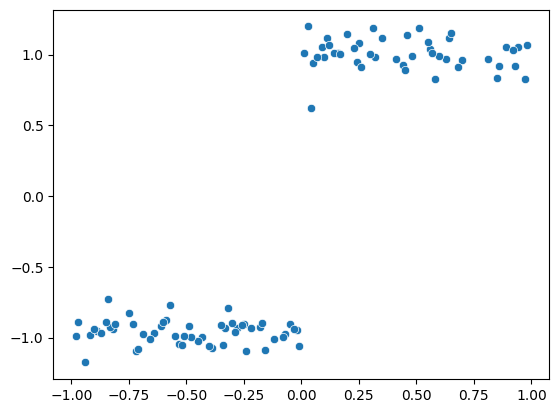

In [20]:
sns.scatterplot(x=x[:, 0], y=y)

In [47]:
with open('outputs/stepfunction_mcmc_gmm_1.pkl', 'rb') as f:
    data = pickle.load(f)

In [50]:
data['pred_x']

[[-10.0],
 [-9.989999771118164],
 [-9.979999542236328],
 [-9.970000267028809],
 [-9.960000038146973],
 [-9.949999809265137],
 [-9.9399995803833],
 [-9.930000305175781],
 [-9.920000076293945],
 [-9.90999984741211],
 [-9.899999618530273],
 [-9.890000343322754],
 [-9.880000114440918],
 [-9.869999885559082],
 [-9.859999656677246],
 [-9.850000381469727],
 [-9.84000015258789],
 [-9.829999923706055],
 [-9.819999694824219],
 [-9.8100004196167],
 [-9.800000190734863],
 [-9.789999961853027],
 [-9.779999732971191],
 [-9.770000457763672],
 [-9.760000228881836],
 [-9.75],
 [-9.739999771118164],
 [-9.729999542236328],
 [-9.720000267028809],
 [-9.710000038146973],
 [-9.699999809265137],
 [-9.6899995803833],
 [-9.680000305175781],
 [-9.670000076293945],
 [-9.65999984741211],
 [-9.649999618530273],
 [-9.640000343322754],
 [-9.630000114440918],
 [-9.619999885559082],
 [-9.609999656677246],
 [-9.600000381469727],
 [-9.59000015258789],
 [-9.579999923706055],
 [-9.569999694824219],
 [-9.5600004196167],
 [-

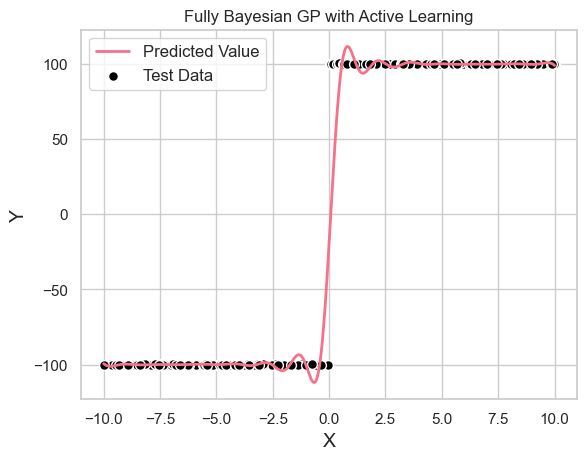

In [67]:
# Set a style and color palette
sns.set(style="whitegrid")
sns.set_palette("husl")

# Create the lineplot with a custom linewidth and label
sns.lineplot(x=np.array(data['pred_x'])[:, 0], y=np.array(data['mean']), ci='sd', linewidth=2, label="Predicted Value")

# Create the scatterplot with custom marker size, edgecolor, and label
sns.scatterplot(x=np.array(data['test_x'])[:, 0], y=np.array(data['test_y']), color='black', s=50, edgecolor='white', linewidth=1, label="Test Data")

# Customize the plot appearance
#plt.title('Mean and Test Data', fontsize=18)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.title('Fully Bayesian GP with Active Learning')

# Add a legend
plt.legend(loc='best', fontsize=12)

# Show the plot
plt.show()



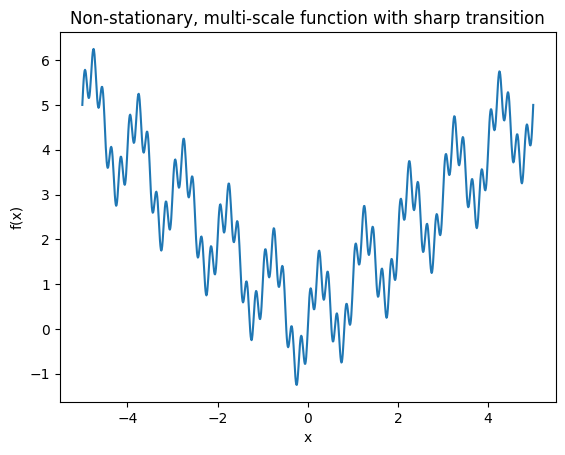

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x, w1, w2, c):
    return np.sin(w1 * x) + 0.5 * np.sin(w2 * x) + np.abs(x - c)

# Define parameters
w1 = 2 * np.pi
w2 = 10 * np.pi
c = 0

# Generate input data
x = np.linspace(-5, 5, 1000)

# Compute the function values
y = f(x, w1, w2, c)

# Plot the function
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Non-stationary, multi-scale function with sharp transition")
plt.show()

In [64]:
import math

import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

from simulators.base import BaseSimulator
from simulators.analytical_simulators import StepFunction

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a Gaussian Process Model


class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self, data_dim):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(1000, 500))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(500, 50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50, 2))

class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class CompositeGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(CompositeGPModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        
         # Matérn kernel with smoothness parameter ν = 1/2
        self.matern_kernel = gpytorch.kernels.MaternKernel(nu=1/2)
        
        self.covar_module = gpytorch.kernels.ScaleKernel(self.matern_kernel)


    def forward(self, x):
        mean_x = self.mean_module(x)

        # Composite kernel: sum of the two RBF kernels
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [66]:
sim = StepFunction()
SEED = 1
x, y = sim.sample_initial_data(50, 'random', SEED)
train_x = x.to(device)
train_y = y.to(device)

data_dim = train_x.size(-1)
feature_extractor = LargeFeatureExtractor(data_dim)

# Initialize the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = GPRegressionModel(train_x, train_y, likelihood).to(device)

# Set the model in training mode
model.train()
likelihood.train()

# Train the model using Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 1000
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))

# Set the model in evaluation mode
model.eval()
likelihood.eval()

# Test points
test_x = torch.linspace(-10, 10, 2001).to(device)
test_y = torch.sin(test_x * (2 * math.pi))

# Predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

Iter 1/1000 - Loss: 1.107
Iter 2/1000 - Loss: 1.091
Iter 3/1000 - Loss: 0.943


KeyboardInterrupt: 